In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

from sklearn.naive_bayes import MultinomialNB

## Data 

https://github.com/justmarkham/pycon-2016-tutorial

In [4]:
url = 'https://raw.githubusercontent.com/justmarkham/pycon-2016-tutorial/master/data/yelp.csv'
df = pd.read_csv(url)
df.head()

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...,review,0hT2KtfLiobPvh6cDC8JQg,0,1,0
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg,1,2,0
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,review,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0


Check for null values

In [5]:
# check for null values
df.isna().sum()

business_id    0
date           0
review_id      0
stars          0
text           0
type           0
user_id        0
cool           0
useful         0
funny          0
dtype: int64

Examine the class distribution

In [6]:
# examine the class distribution
df.stars.value_counts()

4    3526
5    3337
3    1461
2     927
1     749
Name: stars, dtype: int64

## Create a new DataFrame that only contains the 5-star and 1-star reviews.

frame this as a binary classification problem

In [13]:
df_best_worst = df.loc[(df['stars']==1)|(df['stars']==5)]

# class distribution check
df_best_worst.stars.value_counts()

5    3337
1     749
Name: stars, dtype: int64

In [14]:
# shape of dataframe
df_best_worst.shape

(4086, 10)

## Features and labels

In [15]:
X = df_best_worst.drop(columns=['stars'])
y = df_best_worst.stars

In [16]:
print('shape of features',X.shape)
print('shape of labels',y.shape)

shape of features (4086, 9)
shape of labels (4086,)


## Train - Test split

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [25]:
print('Shape of training data',X_train.shape)
print('Shape of training labels',y_train.shape)
print('Shape of testing data',X_test.shape)
print('Shape of testing labels',y_test.shape)

Shape of training data (3064, 9)
Shape of training labels (3064,)
Shape of testing data (1022, 9)
Shape of testing labels (1022,)


## Pipeline 

In [28]:
text_feature = 'text'
text_transformer = CountVectorizer()

preprocessing = ColumnTransformer(transformers=[('text_prep', text_transformer, text_feature)], remainder='drop')

model_pipe = Pipeline(steps=[('preprocess', preprocessing), ('model', MultinomialNB())])

## Training

In [29]:
# train
model_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('text_prep',
                                                  CountVectorizer(),
                                                  'text')])),
                ('model', MultinomialNB())])

In [30]:
# score
model_pipe.score(X_test, y_test)

0.9080234833659491

In [47]:
# predictions
y_preds = model_pipe.predict(X_test)

In [35]:
# Cross validation
cv_score = cross_val_score(model_pipe, X_train, y_train)
print('Cross validation training mean score', cv_score.mean())

Cross validation training mean score 0.9200348654959537


## Confusion matrix

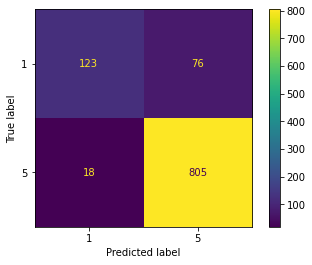

In [38]:
plot_confusion_matrix(model_pipe, X_test, y_test);

In [81]:
# false positives  model say 5 stars but actually 1 star
X_test.loc[(y_test==1)&(y_preds==5), ['text']].head()

,text
1406,"From my door, it's a five minute stroll throug..."
389,I really don't get why everyone is raving this...
2060,This place is closed. Good riddance.
715,What's with the cheese? It isn't even Velveta...
2839,"Never Again,\nI brought my Mountain Bike in (w..."


In [82]:
# false Negative  model say 1 star but actually 5 star

X_test.loc[(y_test==5)&(y_preds==1), ['text']].head()

,text
2504,I've passed by prestige nails in walmart 100s ...
354,We happened upon this location when meeting a ...
750,This store has the most pleasant employees of ...
2127,This place is great! I called at 8:30 am to m...
5736,Thank goodness for Sue at Mill Avenue Travel. ...


## Check Null Accuracy
the classification accuracy that could be achieved by always predicting the most frequent class.

In [39]:
y_test.value_counts()

5    823
1    199
Name: stars, dtype: int64

In [45]:
neu = y_test.value_counts()[5]
deno = y_test.value_counts().sum()

print('Null accuracy ',neu/deno)

Null accuracy  0.8052837573385518


## Predictors

Calculate which 10 tokens are the most predictive of 5-star reviews, and which 10 tokens are the most predictive of 1-star reviews.

Hint: Naive Bayes automatically counts the number of times each token appears in each class, as well as the number of observations in each class. You can access these counts via the `feature_count_` and `class_count_` attributes of the Naive Bayes model object.

In [132]:
# first number is one-star reviews, second number is five-star reviews
model_pipe['model'].class_count_

array([ 550., 2514.])

In [89]:
# first row is one-star reviews, second row is five-star reviews
print('Token count \n', model_pipe['model'].feature_count_)

one_star_token_count = model_pipe['model'].feature_count_[0]
five_star_token_count = model_pipe['model'].feature_count_[1]

print('One star count', one_star_token_count)
print('Five star count', five_star_token_count)

Token count 
 [[28.  4.  1. ...  0.  0.  0.]
 [38.  5.  0. ...  1.  1.  1.]]
One star count [28.  4.  1. ...  0.  0.  0.]
Five star count [38.  5.  0. ...  1.  1.  1.]


In [106]:
# tokens
train_vocab = model_pipe['preprocess'].get_feature_names()
print('length of vocab',len(train_vocab))

length of vocab 16712


In [129]:
# create a DataFrame of tokens with their separate one-star and five-star counts

tokens = pd.DataFrame(data={'Token':train_vocab, 'One star':one_star_token_count, 'Five star':five_star_token_count})

In [130]:
# add 1 to one-star and five-star counts to avoid dividing by 0
tokens['One star'] = tokens['One star']+ 1
tokens['Five star'] = tokens['Five star']+ 1

In [139]:
# convert the one-star and five-star counts into frequencies
tokens['One star'] = tokens['One star'] / model_pipe['model'].class_count_[0]
tokens['Five star'] = tokens['Five star'] / model_pipe['model'].class_count_[1]

In [142]:
tokens['Five star ratio'] = tokens['Five star'] /  tokens['One star']

In [143]:
# sorting
tokens.sort_values(by=['Five star ratio'])

,Token,One star,Five star,Five star ratio
14025,text_prep__staffperson,0.030909,0.000398,0.012869
15514,text_prep__ugh,0.025455,0.000398,0.015627
16627,text_prep__yuck,0.025455,0.000398,0.015627
5843,text_prep__flavorless,0.021818,0.000398,0.018231
4524,text_prep__disgusting,0.041818,0.000796,0.019024
...,...,...,...,...
5606,text_prep__favorite,0.009091,0.122514,13.476531
16632,text_prep__yum,0.001818,0.024662,13.564041
5492,text_prep__fabulous,0.001818,0.031424,17.283214
10906,text_prep__perfect,0.005455,0.097056,17.793689


## Classification - five class
let's repeat the model building process using all reviews, which makes this a 5-class classification problem.

In [149]:
# FEATURES
X = df.drop(columns=['stars'])
y = df['stars']

print('Shape of Features',X.shape)
print('Shape of Labels',y.shape)

# Train - Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
print('Shape of X_train ',X_train.shape)
print('Shape of y_train ',y_train.shape)
print('Shape of X_test ',X_test.shape)
print('Shape of y_test ',y_test.shape)

Shape of Features (10000, 9)
Shape of Labels (10000,)
Shape of X_train  (7500, 9)
Shape of y_train  (7500,)
Shape of X_test  (2500, 9)
Shape of y_test  (2500,)


## Pipeline

In [150]:
# Feature
text_feature = 'text'
# Transformer
text_transformer = CountVectorizer()

# Preprocessing
preprocessing = ColumnTransformer(transformers=[('text', text_transformer, text_feature)], remainder='drop')

# Model building
pipe = Pipeline(steps=[('preprocess', preprocessing), ('model', MultinomialNB())])

## Training 

In [151]:
# train
pipe.fit(X_train, y_train)
# score
pipe.score(X_test, y_test)

0.4932

In [159]:
y_preds = pipe.predict(X_test)

## Confusion matrix

In [158]:
y_test.value_counts()

4    898
5    826
3    374
2    221
1    181
Name: stars, dtype: int64

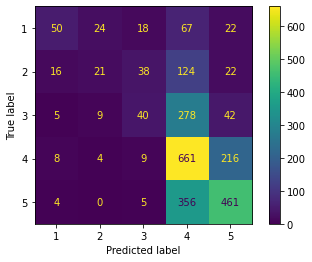

In [152]:
plot_confusion_matrix(pipe, X_test, y_test);

* Nearly all 4-star and 5-star reviews are classified as 4 or 5 stars, but they are hard for the model to distinguish between.
* 1-star, 2-star, and 3-star reviews are most commonly classified as 4 stars, probably because it's the predominant class in the training data.

In [160]:
# print the classification report
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           1       0.60      0.28      0.38       181
           2       0.36      0.10      0.15       221
           3       0.36      0.11      0.17       374
           4       0.44      0.74      0.55       898
           5       0.60      0.56      0.58       826

    accuracy                           0.49      2500
   macro avg       0.48      0.35      0.37      2500
weighted avg       0.49      0.49      0.46      2500



Precision answers the question: "When a given class is predicted, how often are those predictions correct?"

To calculate the precision for class 1, for example, you divide 55 by the sum of the first column of the confusion matrix.

In [178]:
neu = confusion_matrix(y_test, y_preds)[0,0]
deno = confusion_matrix(y_test, y_preds)[:,0]

precision = neu / deno.sum()
print('Precision of class 1 is', precision)

Precision of class 1 is 0.6024096385542169



Recall answers the question: "When a given class is the true class, how often is that class predicted?"

To calculate the recall for class 1, for example, you divide 55 by the sum of the first row of the confusion matrix.

In [179]:
neu = confusion_matrix(y_test, y_preds)[0,0]
deno = confusion_matrix(y_test, y_preds)[0,:]

recall = neu / deno.sum()
print('Recall of class 1 is', recall)

Recall of class 1 is 0.27624309392265195


F1 score is a weighted average of precision and recall.

In [180]:
f1 = 2 * (precision * recall) / (precision + recall)

print('F1 score',f1)

F1 score 0.3787878787878788


Support answers the question: "How many observations exist for which a given class is the true class?"

To calculate the support for class 1, for example, you sum the first row of the confusion matrix.

In [181]:
# support
support = confusion_matrix(y_test, y_preds)[0,:].sum()
print('Support for class 1 is ',support)

Support for class 1 is  181


## Hyper parameter tuning

In [185]:
## utility

def tuner(params, model):
    gs = GridSearchCV(estimator=model, param_grid=params)
    gs.fit(X, y)
    return gs.best_score_

In [197]:
# param-grid
params = {'preprocess__text__stop_words': ['english']}
# tuning
print('Best score ',tuner(params, pipe))

Best score  0.4848


In [198]:
# param-grid
params = {'preprocess__text__ngram_range': [(1,2)]}
# tuning
print('Best score ',tuner(params, pipe))

Best score  0.4434


In [199]:
# param-grid
params = {'preprocess__text__min_df': [2]}
# tuning
print('Best score ',tuner(params, pipe))

Best score  0.5154


In [206]:
# param-grid
params = {'preprocess__text__min_df': [2,4,8,16,32,64]}
# tuning
print('Best score ',tuner(params, pipe))

Best score  0.5275000000000001


In [200]:
# param-grid
params = {'preprocess__text__max_df': [0.9]}
# tuning
print('Best score ',tuner(params, pipe))

Best score  0.49119999999999997


In [203]:
# param-grid
params = {'preprocess__text__stop_words': ['english'],
          'preprocess__text__min_df': [2],
          'preprocess__text__max_df': [0.9]
          }
# tuning
print('Best score ',tuner(params, pipe))

Best score  0.5002


In [205]:
# param-grid
params = {'preprocess__text__stop_words': ['english'],
          'preprocess__text__ngram_range': [(1,2)],
          'preprocess__text__min_df': [5],
          'preprocess__text__max_df': [0.9]
          }
# tuning
print('Best score ',tuner(params, pipe))

Best score  0.5256000000000001


In [208]:
# param-grid
params = {'preprocess__text__stop_words': ['english'],
          'preprocess__text__min_df': [10],
          'preprocess__text__max_df': [0.9]
          }
# tuning
print('Best score ',tuner(params, pipe))

Best score  0.507


In [209]:
# param-grid
params = {'preprocess__text__stop_words': ['english'],
          'preprocess__text__ngram_range': [(1,2)],
          'preprocess__text__min_df': [2,4,8,16,32],
          'preprocess__text__max_df': [0.9]
          }
# tuning
print('Best score ',tuner(params, pipe))

Best score  0.5246000000000001
